In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
FOLDER = '../../data_kaggle/kuzushiji/'
IMAGES = FOLDER + 'train_images/'
print(os.listdir(FOLDER))

['unicode_translation.csv', 'train_images', 'sample_submission.csv', 'train.csv', 'kuzushiji-recognition.zip', 'output', 'test_images']


###  load data

In [3]:
df_train = pd.read_csv(FOLDER + 'train.csv')
df_train_idx = df_train.set_index("image_id")
idx_train = df_train['image_id']
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(FOLDER + 'unicode_translation.csv').values}

### split unicode and coordinate
labels are aligned as 'unicode, x, y, w, t, unicode, x, y, w, h,,,' which can be reshaped matrix (num_char, (code, pos(4-dim))) or (-1, 5)

In [4]:
def label_reader(label):
    try:
        code_arr = np.array(label['labels'].split(' ')).reshape(-1, 5)
    except ValueError as e:
        print(e)
    return code_arr

In [5]:
def get_center(coord):
    return np.vstack([coord[:, 0] + coord[:, 2] //2, coord[:, 1] + coord[:, 3] //2]).T

In [6]:
from sklearn.cluster import KMeans

def get_cluster_n(centers, min_n=3, max_n=10):
    stds_list = []
    for n in range(min_n, max_n):
        km = KMeans(n_clusters=n)
        X = centers.copy()
        X[:, 1] = X[:, 1]/100
        km_cluster = km.fit(X)

        df_center = pd.DataFrame(centers)
        df_center['col_n'] = km_cluster.labels_
        stds_list.append(df_center.groupby('col_n').std().mean().values)

    stds = np.array(stds_list)
    xsm = np.log(stds[:,0])
    n_xsm = np.argmin(xsm[1:] - xsm[:-1]) + 1
    
    return n_xsm + min_n

In [16]:
# idx = idx_train[0]
# df_code = pd.DataFrame(label_reader(df_train_idx.loc[idx]), columns = ['char', 'x', 'y', 'w', 'h'])
# df_code['image_id'] = idx
# df_code = df_code.reset_index()
# df_code[['x','y','w','h']] = df_code[['x','y','w','h']].astype('int')
# coords = df_code[['x','y','w','h']].values
# centers = get_center(coords)
# df_code[['center_x', 'center_y']] = pd.DataFrame(centers)

# n = get_cluster_n(centers)
# X = centers.copy().astype('float')
# X[:, 1] = X[:, 1]/100
# df_code['col_n'] = KMeans(n_clusters=n).fit(X).labels_

# cols = df_code['col_n'].unique()
# new_col_n = np.zeros(0)
# new_index = np.zeros(0)
# for i, col in enumerate(cols):
#     temp = df_code.query('col_n == {}'.format(col))
#     new_index = np.hstack([new_index, temp['index'].values])
#     new_col_n = np.hstack([new_col_n, np.ones(len(temp)) * i])

# del df_code['col_n']
# df_idx = pd.DataFrame([new_index, new_col_n]).T
# df_idx.columns = ['index', 'col_n']
# df_code = pd.merge(df_code, df_idx, on='index').sort_values('col_n', ascending=False).reset_index(drop=True)
# del df_code['index']
# df_code['col_n'] = df_code['col_n'].astype('int')

# cols = df_code['col_n'].unique()
# chars = []
# for col in cols:
#     chars.extend(df_code.query('col_n == {}'.format(col)).sort_values('center_y')['char'].replace(unicode_map))
#     chars.append(' ')

# string = ''
# for c in chars:
#     string += c

# print(string)

In [37]:
def gen_df_code(df_idx, idx):
    df_code = pd.DataFrame(label_reader(df_idx.loc[idx]), columns = ['char', 'x', 'y', 'w', 'h'])
    df_code['image_id'] = idx
    df_code = df_code.reset_index()
    df_code[['x','y','w','h']] = df_code[['x','y','w','h']].astype('int')

    centers = get_center(df_code[['x','y','w','h']].values)
    df_code[['center_x', 'center_y']] = pd.DataFrame(centers)

    X = centers.copy().astype('float')
    X[:, 1] = X[:, 1]/100
    print(get_cluster_n(centers))
    df_code['col_n'] =  KMeans(n_clusters=get_cluster_n(centers)).fit(X).labels_
    
    new_col_n = np.zeros(0)
    new_index = np.zeros(0)
    cols = df_code.sort_values('center_x', ascending=False)['col_n'].unique()
    for i, col in enumerate(cols):
        temp = df_code.query('col_n == {}'.format(col))
        new_index = np.hstack([new_index, temp['index'].values])
        new_col_n = np.hstack([new_col_n, np.ones(len(temp)) * i])

    del df_code['col_n']
    df_new_idx = pd.DataFrame([new_index, new_col_n]).T
    df_new_idx.columns = ['index', 'col_n']
    df_code = pd.merge(df_code, df_new_idx, on='index').sort_values('col_n').reset_index(drop=True)
    del df_code['index']
    df_code['col_n'] = df_code['col_n'].astype('int')

    return df_code

In [38]:
def gen_string(df_code):
    cols = df_code['col_n'].unique()
    chars = []
    for col in cols:
        chars.extend(df_code.query('col_n == {}'.format(col)).sort_values('center_y')['char'].replace(unicode_map))
        chars.append(' ')

    string = ''
    for c in chars:
        string += c

    print(string)

In [39]:
idx = idx_train[0]
df_code = gen_df_code(df_train_idx, idx)
gen_string(df_code)

6
自序 若い時の気強に己やれと思ふ た細工も老武者のかなしさは 息子に及ず浮世を裏の三畳に 避て正風の俳諧を楽しめ ども根が職人の文盲だけこそけれ 


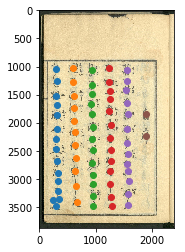

In [40]:
image_path = IMAGES + idx + '.jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for col in cols:
    centers = df_code.query('col_n == {}'.format(col))[['center_x','center_y']].values
    plt.scatter(centers[:,0], centers[:,1])
plt.imshow(img)
plt.show()

6
自序 若い時の気強に己やれと思ふ た細工も老武者のかなしさは 息子に及ず浮世を裏の三畳に 避て正風の俳諧を楽しめ ども根が職人の文盲だけこそけれ 


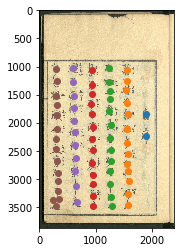

6
が啁につかへらんらめらしもらつし こくたいされとも人間活物にて 心を使ふか手足をつかふか じっとしては居られぬならひ 醤で茶漬をしてやりながら 思ひ付たる物類名義年久しく 


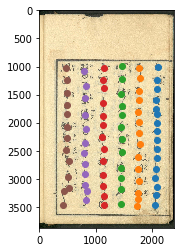

6
住む馬食町の食ふといふから始 りて先食物の故事付案事仮 名違ひやらあて字やら訛片言 あたりまへめったやたらに書つ づれは其数几て何十条是より 次第に嘘が上り天門地理と 


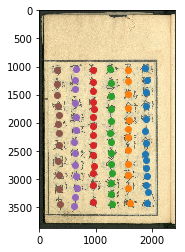

6
門部をわけ追々嘘をつきなら はゞ嘘八百にも満ぬべし然るを 近処の書林何某これも同じ く嘘つき弥次郎薮の中で 屁をひりあふ交り浅からず 我嘘を梓に鋳め己嘘の 


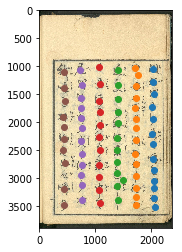

8
虚南留別志巻之上江戸木屑庵述 飯めしいいはんまんま ▲命司めめいししなをるつべめてしめしいのちをつかさどるの宝なるゆへ まんまはまゝなるべしすべて物をつぐをまゝといふいのちを つぐまた母の無き子後の母をたのみ育をまゝ母といふ も子の命をつぐゆへにまゝはゝなるべし ▲意根世根何れも米の名いのちの根なり ▲汁しるはつけなるべしめしのかたはらに付て食ふ 


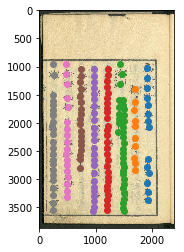

8
ゆへつけおの字をそへておつけか又 けの字しるなり ▲菜さいはそへて食ふゆへにさへなるべしそとさと通ず ▲香物はにほふ故にかふ〱なるべし ▲爰に膳にならぶ所の具によりて食類の惣名とする ものなり平坪猪口鱠 是は家具の考にいふなれども食にならぶ故先考を こゝに解 


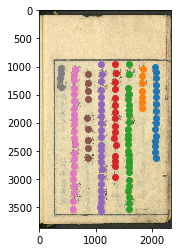

8
▲開ひらくの略ひらなるべし ▲蕾つぼむの略つぼなるべし 有来り用ゆる文字の坪は地坪の預る所ゆへ土へん也 膳部にはあやまりなるか ▲しばらく食類をさし置て家具の考をとく むかし大和国に和気の棟春といふ人あり何れの事にも 才能ある者にて土にて挽物器作るより考付て挽台を よこに用ひ色々の堅木をもってうつわを挽出す工夫を 


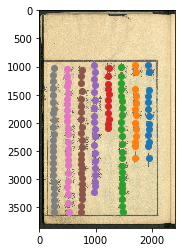

8
なせり大となく小となく或は浅く深くさま〱の器を挽 出せり近郷の貴賎はなはだ調法して悦び日々繁栄せり 後々はやごとなき御方へもさし上るやうになりける爰において 名あるべくと人々の問ふに名はいまだ考へずと申けり其ころ或 先生和気が宅へ朝暮あそびに来り給ふゆへ棟春この 人について曰我が工夫にて製し来る所の器いまだ名これ なし衆人名あってこそ然るべけれと望む先生是に名を ほどこし給へと頼みければ先生考へて箇やうの品に名を 


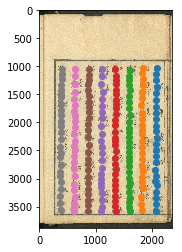

8
付る事よふいならず是は天地自然の数をもって付 宣しきと申きあるじこたへて数とはいかにと申ければ小の数 を三といゝ大の数を八といふ故に大なるを八ととなへ小成を 三と申ていかにとぞ申ける是奇なりとて大をはちと小を三 といひなせりすべて大成を餅など入て木ばち火を入 て火ばち余はこれになぞらへてしるべし又小の 具三のすうへらの文字を添てさんらあさきうつわ をおさんなどゝいひならはし今もさかづきにこの名 


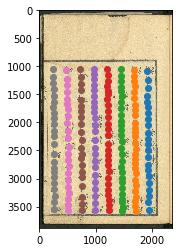

8
あり ▲又是よりめししるを食ふべき器を案んじ挽 出せり尤いにしへは土器にてすみしものなり又五 器といふものあり右は天笠仏在世のとき鉄にて 製し五つ組に作りしてつぱつともいふこれは 直に下より火をたき鍋かれこれに用ひ五つ組もの ゆへに五きといふかあるじの工夫は四つ組にてきせ ふたをかねたり是にも名を付んと例の先生へ 


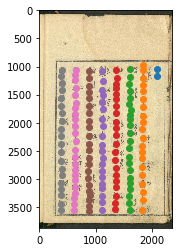

In [52]:
for idx in idx_train[:10]:
    df_code = gen_df_code(df_train_idx, idx)
    gen_string(df_code)

    image_path = IMAGES + idx + '.jpg'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cols = df_code['col_n'].unique()
    for col in cols:
        centers = df_code.query('col_n == {}'.format(col))[['center_x','center_y']].values
        plt.scatter(centers[:,0], centers[:,1])
    plt.imshow(img)
    plt.show()